## **Amazon Sentiment Analysis using Logistic Regression and SVM** 

### **About the dataset:**

The Amazon reviews full score dataset is constructed by randomly taking 600,000 training samples and 130,000 testing samples for each review score from 1 to 5. In total there are 3,000,000 trainig samples and 650,000 testing samples.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 5), review title and review text. The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

Dataset link: https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ

Kaggle link: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/data

In [1]:
import re
import nltk
import pickle
import pandas as pd
import numpy as np
import requests
import joblib

In [2]:
# Data processing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
# Feature extraction
!pip install yellowbrick
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [5]:
# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
# Data Visualization
!pip install wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from PIL import Image
from wordcloud import WordCloud,  ImageColorGenerator

Defaulting to user installation because normal site-packages is not writeable


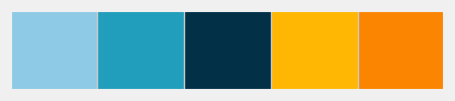

In [7]:
style.use("fivethirtyeight")
colors = ["#8ecae6", "#219ebc", "#023047", "#ffb703", "#fb8500"]
palette = sns.color_palette(colors)
sns.palplot(sns.color_palette(colors))
plt.show()
style.use("fivethirtyeight")

#### **Importing the Dataset:**

In [8]:
data = pd.read_csv('./train.csv', header=None)
data.head(10)

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,4,"Errors, but great story",I was a dissapointed to see errors on the back...
8,1,The Worst!,A complete waste of time. Typographical errors...
9,1,Oh please,I guess you have to be a romance novel lover f...


In [9]:
data.shape

(3000000, 3)

#### **Modifying the Dataset:**

We first name the columns as "Rating", "Title" and "Review".

In [10]:
data.columns = ["Rating", "Title", "Review"]
data.head()

,Rating,Title,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


We then combine the "Review" and "Title" column into one, as it should not contradict the overall sentiment.

In [11]:
data["Review"] = data["Title"] + " " + data["Review"]
data = data[['Review', 'Rating']]
data.head()

,Review,Rating
0,more like funchuck Gave this to my dad for a g...,3
1,Inspiring I hope a lot of people hear this cd....,5
2,The best soundtrack ever to anything. I'm read...,5
3,Chrono Cross OST The music of Yasunori Misuda ...,4
4,Too good to be true Probably the greatest soun...,5


The sentiment to each review is added by considering a rating above 3 as "Positive", below 3 as "Negative" and equal to 3 as "Neutral".

In [12]:
def sentiment(label):
    if label<3:
        return "Negative"
    elif label>3:
        return "Positive"
    else:
        return "Neutral"

In [13]:
data['Sentiment'] = data["Rating"].apply(sentiment)
data.head(10)

,Review,Rating,Sentiment
0,more like funchuck Gave this to my dad for a g...,3,Neutral
1,Inspiring I hope a lot of people hear this cd....,5,Positive
2,The best soundtrack ever to anything. I'm read...,5,Positive
3,Chrono Cross OST The music of Yasunori Misuda ...,4,Positive
4,Too good to be true Probably the greatest soun...,5,Positive
5,There's a reason for the price There's a reaso...,5,Positive
6,"Buyer beware This is a self-published book, an...",1,Negative
7,"Errors, but great story I was a dissapointed t...",4,Positive
8,The Worst! A complete waste of time. Typograph...,1,Negative
9,Oh please I guess you have to be a romance nov...,1,Negative


#### **Data Analysis:**

In [14]:
data.shape

(3000000, 3)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Review     object
 1   Rating     int64 
 2   Sentiment  object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [16]:
data.value_counts("Rating")

Rating
1    600000
2    600000
3    600000
4    600000
5    600000
Name: count, dtype: int64

In [17]:
data.value_counts("Sentiment")

Sentiment
Negative    1200000
Positive    1200000
Neutral      600000
Name: count, dtype: int64

C:\Users\srinj\AppData\Local\Temp\ipykernel_11840\2359462227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])


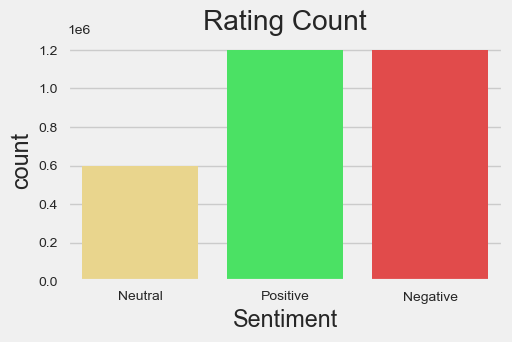

In [18]:
plt.figure(figsize=(5,3))
sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])
plt.title("Rating Count")
plt.show()

In [19]:
data["Rating"].value_counts()/len(data)

Rating
3    0.2
5    0.2
4    0.2
1    0.2
2    0.2
Name: count, dtype: float64

In [20]:
data["Sentiment"].value_counts()/len(data)

Sentiment
Positive    0.4
Negative    0.4
Neutral     0.2
Name: count, dtype: float64

In [21]:
data.isna().sum()

Review       188
Rating         0
Sentiment      0
dtype: int64

We can see that there are no null values in Ratings or Sentiments, so we do not have to drop any rows.
However, there are 188 rows that are empty, so we fill it with an empty string.

In [22]:
data = data.fillna(' ')
data.isna().sum()

Review       0
Rating       0
Sentiment    0
dtype: int64

**Number of characters present in each Review:**

Here I range the number of characters by 500 chars and so on.

In [23]:
text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()
text_len.head()

C:\Users\srinj\AppData\Local\Temp\ipykernel_11840\2468471289.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(), np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()


,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885
3,"(1500, 2000]",0
4,"(2000, 2500]",0


In [24]:
text_len_50 = text_len[text_len['Review'] > 50]
text_len_50

,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885


C:\Users\srinj\AppData\Local\Temp\ipykernel_11840\4000903183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\srinj\AppData\Local\Temp\ipykernel_11840\4000903183.py:2: UserWarning: 
The palette list has fewer values (5) than needed (40) and will cycle, which may produce an uninterpretable plot.
  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\srinj\AppData\Local\Temp\ipykernel_11840\4000903183.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


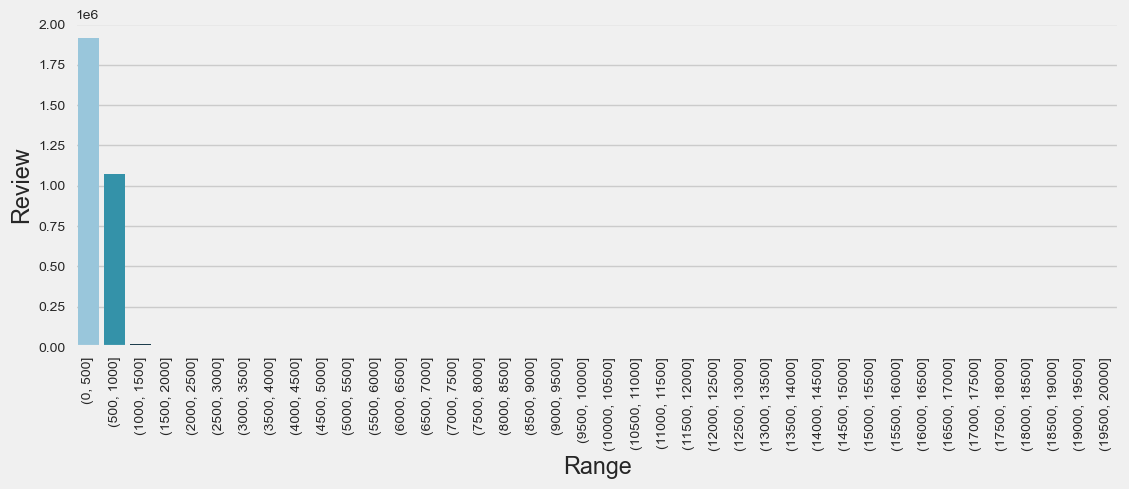

In [25]:
plt.figure(figsize=(12, 4))
g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

C:\Users\srinj\AppData\Local\Temp\ipykernel_11840\1778809724.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)


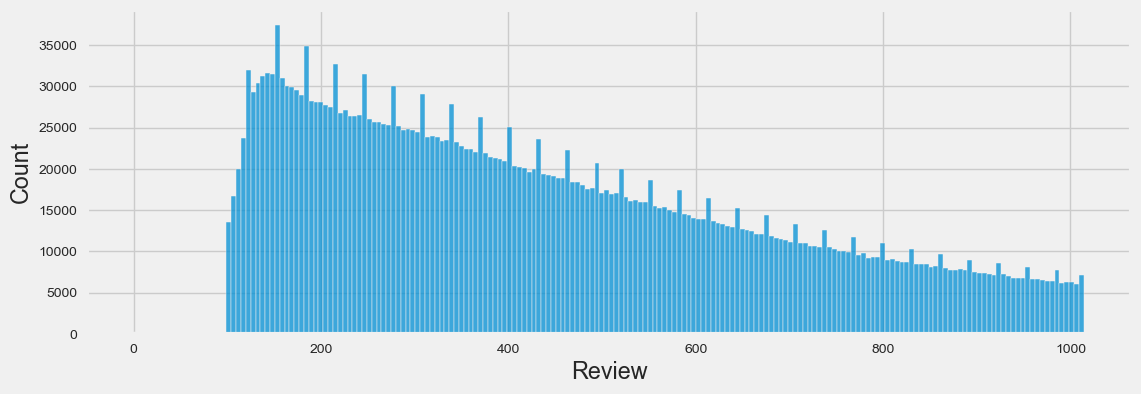

In [26]:
plt.figure(figsize=(12, 4))
sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)
plt.show()

#### **Sampling the data:**
Since there are over 35 million reviews in this dataset, we will only use a portion of this for training our models. We will use Stratified Shuffle Split for this.

Benefits of StratifiedShuffleSplit:

- Maintains class balance: This is crucial for sentiment analysis where you have different classes representing positive, negative, and neutral reviews. Stratified sampling ensures the sampled data reflects the same proportion of each class as your original dataset, preventing biases in your model's training.
- Reduces computational cost: Training on a smaller sample is significantly faster and less resource-intensive compared to using the entire dataset.
- Provides representative data: Stratified sampling ensures the selected data is representative of the entire population, leading to a more robust and generalizable model.

In [27]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.97)
for train_index, test_index in split.split(data, data["Sentiment"]): 
    strat_data = data.reindex(train_index)

In [28]:
strat_data.head(10)

,Review,Rating,Sentiment
2877545,Insightful and articualate I can't believe the...,5,Positive
2477073,"Not terrific, will use my other products inste...",3,Neutral
118683,disappointed Despite numerous e-mails to every...,1,Negative
761306,meh not much to say. i found all the waldos ea...,2,Negative
320440,What is going on here... The action was good i...,2,Negative
1429635,Would rather use something else When I bought ...,3,Neutral
1675641,Works very well when there's no breeze. I have...,4,Positive
1137603,characters faithful to the show Nice continuat...,5,Positive
618513,Cheaper at Costco I just bought this plasma ca...,2,Negative
2347837,So so I'm not sure what possessed me to order ...,3,Neutral


We take a sample dataset of 75000 rows.

In [29]:
strat_data.shape

(90000, 3)

In [30]:
strat_data.value_counts("Sentiment")

Sentiment
Negative    36000
Positive    36000
Neutral     18000
Name: count, dtype: int64

#### **Cleaning data:**

Cleaning data includes

- Tokenization: Tokenization is the process of converting text into tokens before transforming it into vectors. 
- Stop Words Removal: Stop words are the most commonly occuring words which are not relevant in the context of the data and do not contribute any deeper meaning to the phrase. 
- Normalization: Words which look different due to casing or written another way but are the same in meaning need to be process correctly. Normalisation processes ensure that these words are treated equally. This includes:
    - Casing the characters: Converting character to the same case so the same words are recognised as the same. In this case we converted to lowercase
    - Negation Handling
- Lemmetization: This process finds the base or dictionary form of the word known as the lemma.

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\srinj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
def preprocess_text(text):
    # Make text lowercase and remove links, text in square brackets, punctuation, and words containing numbers
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', ' ', text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lem_tokens)

For example:

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
preprocess_text(data["Review"][2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srinj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\srinj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'best soundtrack ever anything reading lot review saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening year beauty simply refuse fade price tag pretty staggering must say going buy cd much money one feel would worth every penny'

In [34]:
preprocess_text(data["Review"][110])

'fabulous book completely instrumental guiding husband timberframing pursuit read much cover binding fallen broken hold best reference diyer look starting structure'

We do the same for all the reviews in the dataset.

In [35]:
strat_data["Review"] = strat_data["Review"].apply(preprocess_text)
strat_data.head(10)

,Review,Rating,Sentiment
2877545,insightful articualate believe review pan wond...,5,Positive
2477073,terrific use product instead typically useorth...,3,Neutral
118683,disappointed despite numerous e mail everyone ...,1,Negative
761306,meh much say found waldos easily think took fi...,2,Negative
320440,going action good movie everything else crap p...,2,Negative
1429635,would rather use something else bought yogurt ...,3,Neutral
1675641,work well breeze using lantern summer live flo...,4,Positive
1137603,character faithful show nice continuation show...,5,Positive
618513,cheaper costco bought plasma car amazon awesom...,2,Negative
2347837,sure possessed order thermometer online instea...,3,Neutral


#### **Word Cloud:**

In [36]:
txt = "".join(strat_data["Review"].tolist())

In [37]:
len(txt)

24059271

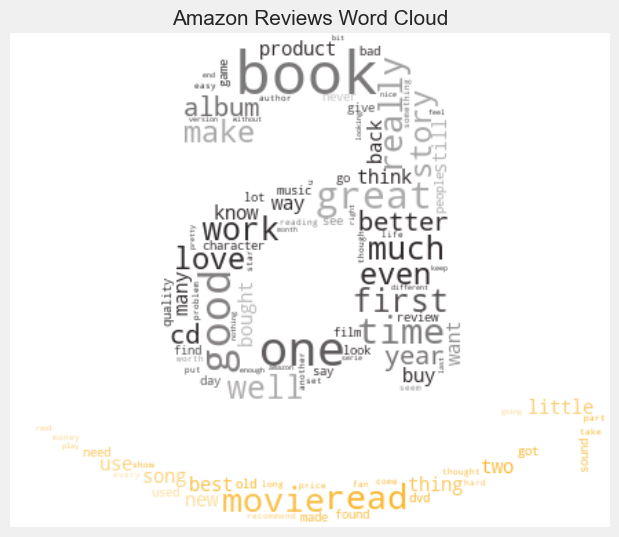

In [38]:
amazon_mask = np.array(Image.open(requests.get('https://pngimg.com/uploads/amazon/amazon_PNG4.png', stream=True).raw))

wc = WordCloud(width = 300, height = 200, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=amazon_mask).generate(txt)
image_colors = ImageColorGenerator(amazon_mask)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.title("Amazon Reviews Word Cloud", fontsize = 15)
plt.savefig('wordcloud.png')
plt.show()

TF IDF SCORE

In [40]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))

In [41]:
X_tfidf = tfidf_vectorizer.fit_transform(strat_data['Review'])
X_tfidf

<90000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2804668 stored elements in Compressed Sparse Row format>

In [42]:
X_tfidf.shape

(90000, 5000)

In [43]:
y = strat_data["Sentiment"]

In [44]:
y.shape

(90000,)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42,test_size = 0.20)

In [46]:
print(X_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(X_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")

(72000, 5000)
Number of Training Samples: 72000
(72000,)
Number of Training Samples: 72000
(18000, 5000)
Number of Training Samples: 72000
(18000,)
Number of Training Samples: 72000


In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [48]:
predictedLogReg = logreg.predict(X_test)
np.mean(predictedLogReg == y_test)

0.7155555555555555

In [49]:
inp_test = input("Enter review: ")
print(inp_test)

inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

inp_test = tfidf_vectorizer.transform([inp_test])
logreg.predict(inp_test)

Enter review:  It is a bad product


It is a bad product
After preprocessing:  bad product


array(['Negative'], dtype=object)


This code snippet is for predicting sentiment (e.g., "Positive" or "Negative") of a review using text preprocessing, feature extraction, and a trained logistic regression model:

Input Review: The user provides a review (e.g., "It is a bad product").
Preprocessing: The review is preprocessed (e.g., removing stopwords or punctuation) to simplify the text ("bad product").
Feature Transformation: The preprocessed text is converted into numerical features using a TF-IDF vectorizer (tfidf_vectorizer).
Prediction: A trained logistic regression model (logreg) predicts the sentiment of the review. The output here indicates "Negative" sentiment.
